In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hashlib

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, c="k", alpha=0.75, zorder=0)
    ax.set(**{"aspect": "equal", "xlim": lims, "ylim": lims})
    return ax

def short_hash(s: str) -> str:
    """Generate a 7-character hash from a given string."""
    return hashlib.sha256(s.encode()).hexdigest()[:7]

fsize = 15
plt.rcParams.update({"font.size": fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
from taln.taln_aln import (
    norm_text,
    tokenize,
    align_ng, 
    align_lcs,
    align_difflib,
    reconstruct_target_by_token,
)

In [3]:
# ablate target
import random
def ablate_custom(target, ttype="whitespace"):
    tokens, _ = tokenize(target, ttype)
    ablidx = random.randint(1, len(tokens) - 2) # don't want it to be first or last token
    tokens.pop(ablidx)
    recon_ans = reconstruct_target_by_token("", tokens) if ttype == "token" else reconstruct_target_by_token("", tokens, " ")
    if target[0] == " " and ttype:
        recon_ans = " " + recon_ans
    return recon_ans, ablidx

In [4]:
cols = ["title", "question", "question_id", "is_impossible", "answer_type"]

In [5]:
# post shift (consistent with subword tokenization)
tdf = pd.read_json("../data/shift_train.lst.json", orient="records").drop(columns=cols)
tdf["hash_source"] = tdf["source"].apply(short_hash)
tdf["hash_target"] = tdf["target"].apply(short_hash)

# load whitespace tokenized data
wdf = pd.read_json("../data/clean_train.lst.json", orient="records").drop(columns=cols)
wdf["hash_source"] = tdf["hash_source"]
wdf["hash_target"] = tdf["hash_target"]

# keep multi-token targets
tdf = tdf[tdf["target"].str.split().str.len() > 2]

# perform ablation
tdf[["ablate_target", "ablate_idx"]] = tdf["target"].apply(ablate_custom).apply(pd.Series)

# retain hash index to map ablated tokens to tdf frame
hash_idx = tdf[["hash_source", "hash_target", "ablate_target", "ablate_idx"]].drop_duplicates()

# group the duplicate source/target pairs (i.e. the same source/targets with multiple mappings)
tdf = tdf.groupby(["hash_source", "hash_target", "source", "target"])["idx_start"].apply(set).reset_index()

# merge the ablated target with the original source/target pairs
tdf = tdf.merge(
    hash_idx,
    on=["hash_source", "hash_target"],
    how="left"
).set_index(["hash_source", "hash_target"])

# group the duplicate source/target pairs (i.e. the same source/targets with multiple mappings) by whitespace, keep only those in the tdf
wdf = wdf.groupby(["hash_source", "hash_target", "source", "target"])["idx_start"].apply(set).reset_index().set_index(["hash_source", "hash_target"]).loc[tdf.index]

# merge the ablated target with the original source/target pairs
wdf[["ablate_target", "ablate_idx"]] = tdf[["ablate_target", "ablate_idx"]]



In [6]:
tdf.shape, wdf.shape

((44306, 5), (44306, 5))

In [7]:
import time
# Apply function with timing
def timed_align(x, fn, ttype): # fn takes in source and target
    start_time = time.time()
    ctx = x["source"]
    tgt = x["ablate_target"]

    if ttype == "whitespace":
        tgt = tgt.strip()

    result = fn(ctx, tgt, ttype)
    end_time = time.time()

    # Calculate elapsed time in milliseconds
    t = (end_time - start_time) * 1000
    return result, t

def align_naive(ctx, tgt, ttype):
    if tgt in ctx:
        idx = ctx.index(tgt)
        found = {
            "token": tgt,
            "enc_token": -1, 
            "start_idx": ctx.index(tgt),
            "end_idx": idx + len(tgt),
        }
        return [[found]]
    else:
        return [[]]

methods = {
    "custom": align_ng,
    "lcs": align_lcs,
    "difflib": align_difflib,
    "naive": align_naive,
}



In [8]:
for m in methods:
    # alignments and time
    tdf[[f"{m}_aln", f"{m}_time_ms"]] = tdf.apply(
        timed_align, axis=1, result_type="expand", args=(methods[m],"token")
    )

    # num alignments
    tdf[f"{m}_len"] = tdf[f"{m}_aln"].apply(len)

    tdf[f"{m}_idx_start"] = tdf[f"{m}_aln"].apply(lambda x: set([i[0].get("start_idx", -1) for i in x]) if len(x)>0 and len(x[0])>0 else {-1})

    tdf[f"{m}_text"] = tdf[f"{m}_aln"].apply(lambda x: reconstruct_target_by_token("", x[0] if len(x)>0 else ""))
    tdf[f"{m}_same"] = tdf["ablate_target"] == tdf[f"{m}_text"]


In [9]:
for m in methods:
    # alignments and time
    wdf[[f"{m}_aln", f"{m}_time_ms"]] = wdf.apply(
        timed_align, axis=1, result_type="expand", args=(methods[m], "whitespace")
    )

    # num alignments
    wdf[f"{m}_len"] = wdf[f"{m}_aln"].apply(len)

    wdf[f"{m}_idx_start"] = wdf[f"{m}_aln"].apply(lambda x: set([i[0].get("start_idx", -1) for i in x]) if len(x)>0 and len(x[0])>0 else {-1})

    wdf[f"{m}_text"] = wdf[f"{m}_aln"].apply(lambda x: reconstruct_target_by_token("", x[0] if len(x)>0 else "", " "))
    wdf[f"{m}_same"] = wdf["ablate_target"].str.strip() == wdf[f"{m}_text"].str.strip()

In [10]:
# compare to the start
def compute_set_operations(x, real_idx="idx_start", pred_idx="custom_idx_start", vals=False):
    set1 = x[real_idx]
    set2 = x[pred_idx]

    left_diff = set1 - set2  # Elements in set1 but not in set2
    intersection = set1 & set2  # Common elements
    right_diff = set2 - set1  # Elements in set2 but not in set1

    if vals:
        return pd.Series([left_diff, intersection, right_diff])
    else:
        return pd.Series([len(left_diff), len(intersection), len(right_diff)])

# token ops
for m in list(methods.keys()):

    tdf[[f"{m}_lv", f"{m}_xv", f"{m}_rv"]] = tdf.apply(lambda x: compute_set_operations(x, real_idx= "idx_start", pred_idx=f"{m}_idx_start", vals=True), axis=1)
    tdf[[f"{m}_l", f"{m}_x", f"{m}_r"]] = tdf.apply(lambda x: compute_set_operations(x, real_idx= "idx_start", pred_idx=f"{m}_idx_start"), axis=1)
    tdf[f"{m}_found"] = tdf.apply(
        lambda x: x[f"{m}_l"] == 0, axis=1
    )

# whitespace ops
for m in list(methods.keys()):

    wdf[[f"{m}_lv", f"{m}_xv", f"{m}_rv"]] = wdf.apply(lambda x: compute_set_operations(x, real_idx= "idx_start", pred_idx=f"{m}_idx_start", vals=True), axis=1)
    wdf[[f"{m}_l", f"{m}_x", f"{m}_r"]] = wdf.apply(lambda x: compute_set_operations(x, real_idx= "idx_start", pred_idx=f"{m}_idx_start"), axis=1)
    wdf[f"{m}_found"] = wdf.apply(
        lambda x: x[f"{m}_l"] == 0, axis=1
    )
    

In [11]:
# custom
print(tdf["custom_same"].sum()/tdf.shape[0]*100)
print(tdf["lcs_same"].sum()/tdf.shape[0]*100)
print(tdf["difflib_same"].sum()/tdf.shape[0]*100)
print(tdf["naive_same"].sum()/tdf.shape[0]*100)

98.17406220376472
98.4336207285695
95.1202997336704
0.5078318963571525


In [12]:
# custom
print(wdf["custom_same"].sum()/wdf.shape[0]*100)
print(wdf["lcs_same"].sum()/wdf.shape[0]*100)
print(wdf["difflib_same"].sum()/wdf.shape[0]*100)
print(wdf["naive_same"].sum()/wdf.shape[0]*100)

52.191576761612424
52.32248453934004
50.28664289261048
0.5574865706676296


In [13]:
tacc = tdf.assign(ntks_ctx=tdf["source"].apply(lambda x: len(tokenize(x)[0]))) \
    .groupby("ntks_ctx")[["custom_found", "lcs_found", "difflib_found", "naive_found"]] \
    .agg(lambda x: x.sum() / x.count() * 100)

wacc = wdf.assign(ntks_ctx=wdf["source"].apply(lambda x: len(tokenize(x)[0]))) \
    .groupby("ntks_ctx")[["custom_found", "lcs_found", "difflib_found", "naive_found"]] \
    .agg(lambda x: x.sum() / x.count() * 100)

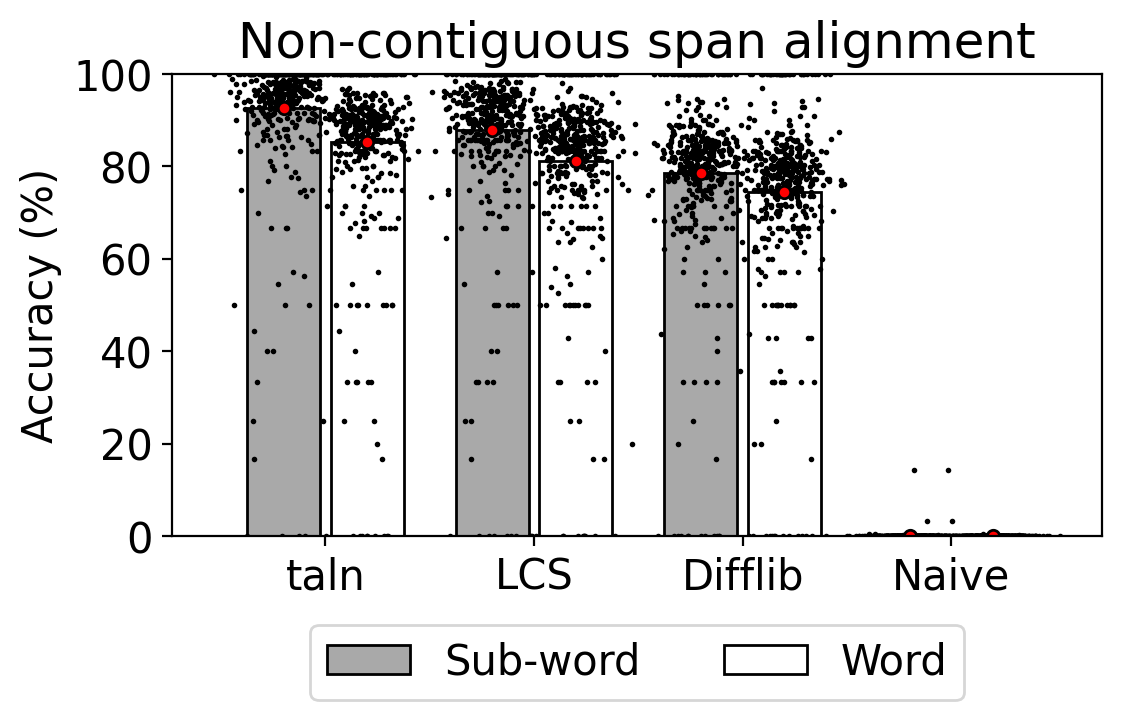

In [44]:
fig, ax = plt.subplots(figsize=(6,3))

x = np.arange(4)
width = 0.35  # Narrower bars for side-by-side
gap = 0.025

# First bar set (tacc)
for idx, (i, y) in enumerate(tacc.items()):
    x_vals = np.random.normal(idx - (width/2 + gap), 0.1, size=len(y))
    ax.scatter(x_vals, y.values, s=1, alpha=1, color="k")
    ax.bar(idx - (width/2 + gap), y.mean(), width, zorder=-1,
           edgecolor="black", facecolor="darkgrey")
    ax.scatter(idx - (width/2 + gap), y.mean(), s=20, zorder=1,
           edgecolor="black", facecolor="red")

# Second bar set (wacc)
for idx, (i, y) in enumerate(wacc.items()):
    x_vals = np.random.normal(idx + (width/2 + gap), 0.1, size=len(y))
    ax.scatter(x_vals, y.values, s=1, alpha=1, color="k")
    ax.bar(idx + (width/2 + gap), y.mean(), width, zorder=-1,
           edgecolor="black", facecolor="white")
    ax.scatter(idx + (width/2 + gap), y.mean(), s=20, zorder=1,
           edgecolor="black", facecolor="red")

ax.set(**{
    "ylabel": "Accuracy (%)",
    "xticks": np.arange(4),
    "xticklabels": ["taln", "LCS", "Difflib", "Naive"],
    "ylim": (0, 100),
})

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="darkgrey", edgecolor="black", label="Sub-word"),
    Patch(facecolor="white", edgecolor="black", label="Word"),
]
# ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), markerscale=3)
ax.legend(
    handles=legend_elements,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.4),
    ncol=2,
    frameon=True
)
ax.set_title("Non-contiguous span alignment")
plt.show()

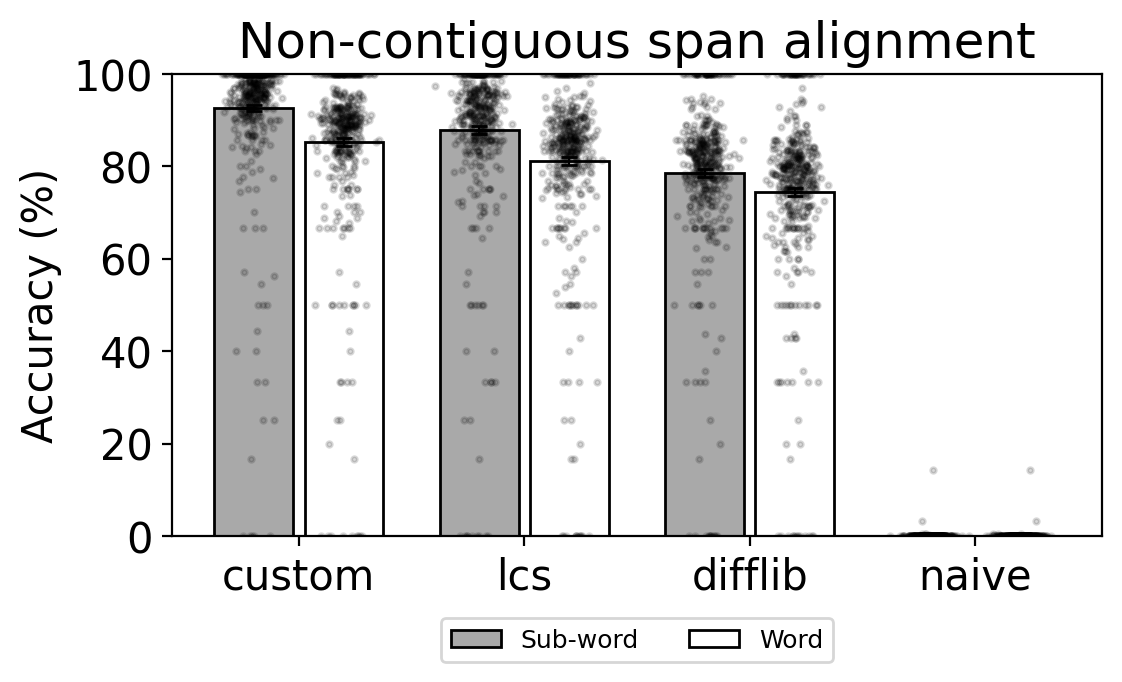

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(6, 3))

# same mapping as before
methods = {"taln": "custom", "LCS": "lcs", "Difflib": "difflib", "Naive": "naive"}
x = np.arange(len(methods))

width = 0.35
gap = 0.025
jitter_sd = 0.05

def mean_sem(vals):
    vals = np.asarray(vals)
    m = vals.mean()
    s = vals.std(ddof=1) / np.sqrt(len(vals))
    return m, s

# --- sub-word (tacc, non-contiguous) -----------------------------------------
for idx, (label, m) in enumerate(methods.items()):
    # adjust key/indexing here to match how you store non-contiguous accuracies
    y = tacc[f"{m}_found"]   # or tacc[m] if your object is dict-like
    y_mean, y_sem = mean_sem(y)

    # jittered points
    x_vals = np.random.normal(idx - (width/2 + gap), jitter_sd, size=len(y))
    ax.scatter(
        x_vals, y,
        s=4,
        alpha=0.15,
        color="k",
        zorder=1,
    )

    center = idx - (width/2 + gap)

    # bar for mean
    ax.bar(
        center, y_mean,
        width,
        zorder=0,
        edgecolor="black",
        facecolor="darkgray",
    )

    # error bar
    ax.errorbar(
        center, y_mean,
        yerr=y_sem,
        fmt="none",
        ecolor="black",
        elinewidth=0.8,
        capsize=3,
        zorder=2,
    )

# --- word (wacc, non-contiguous) ---------------------------------------------
for idx, (label, m) in enumerate(methods.items()):
    # again, adjust key/indexing as needed
    y = wacc[f"{m}_found"]   # or wacc[m]
    y_mean, y_sem = mean_sem(y)

    x_vals = np.random.normal(idx + (width/2 + gap), jitter_sd, size=len(y))
    ax.scatter(
        x_vals, y,
        s=4,
        alpha=0.15,
        color="k",
        zorder=1,
    )

    center = idx + (width/2 + gap)

    ax.bar(
        center, y_mean,
        width,
        zorder=0,
        edgecolor="black",
        facecolor="white",
    )

    ax.errorbar(
        center, y_mean,
        yerr=y_sem,
        fmt="none",
        ecolor="black",
        elinewidth=0.8,
        capsize=3,
        zorder=2,
    )

# --- axes / labels -----------------------------------------------------------
ax.set(
    ylabel="Accuracy (%)",
    xticks=x,
    xticklabels=list(methods.values()),
    ylim=(0, 100),
    title="Non-contiguous span alignment",
)

# legend
legend_elements = [
    Patch(facecolor="darkgray", edgecolor="black", label="Sub-word"),
    Patch(facecolor="white", edgecolor="black", label="Word"),
]

ax.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=2,
    frameon=True,
    fontsize=9,
)

plt.show()

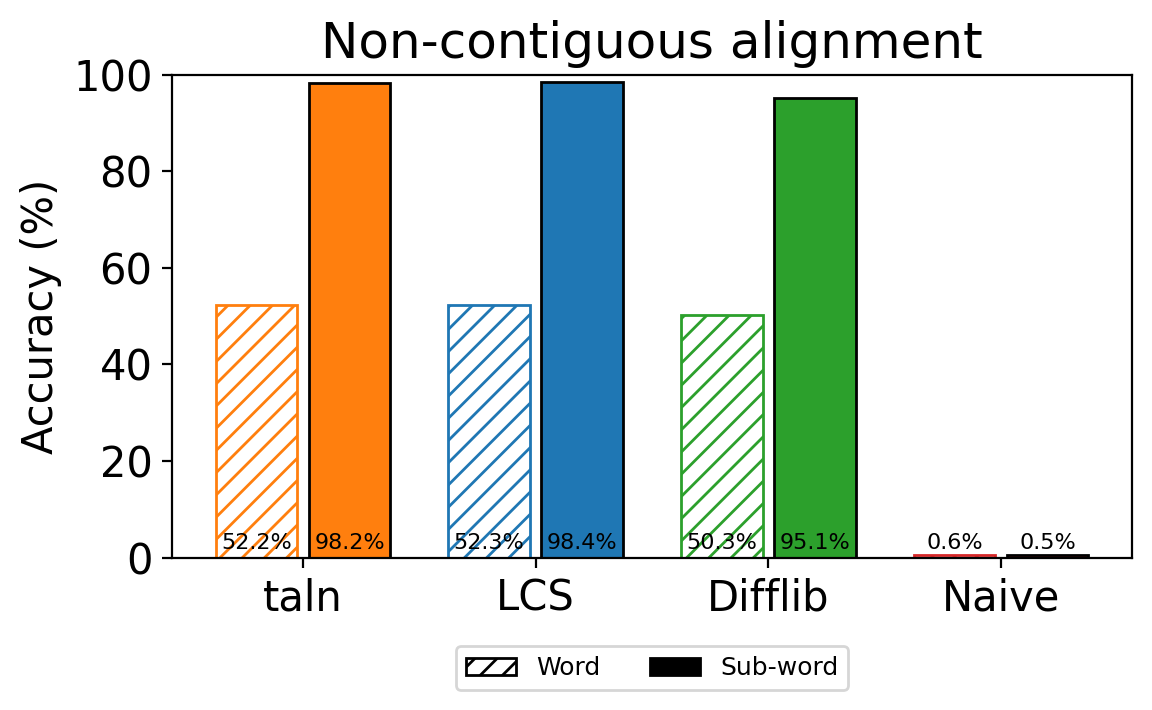

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

COLORS = {
    "lcs":     "#1f77b4",  # blue
    "custom":  "#ff7f0e",  # orange
    "difflib": "#2ca02c",  # green
    "naive":   "#d62728",  # red
}


fig, ax = plt.subplots(figsize=(6, 4))

methods = {"taln": "custom", "LCS": "lcs", "Difflib": "difflib", "Naive": "naive"}
x = np.arange(len(methods))

width = 0.35
gap = 0.025

# --- sub-word (per-sample accuracy, non-contiguous) ---------------------------
for idx, (label, m) in enumerate(methods.items()):
    y = 100 * tdf[f"{m}_same"].astype(int)
    y_mean = y.mean()

    center = idx + (width/2 + gap)

    ax.bar(
        center, y_mean, width, zorder=0,
        edgecolor="black",
        facecolor=COLORS[m],   # solid method color
    )

    ax.text(center, 1, f"{y_mean:.1f}%",
            ha="center", va="bottom", fontsize=8)

# --- word (per-sample accuracy, non-contiguous) -------------------------------
for idx, (label, m) in enumerate(methods.items()):
    y = 100 * wdf[f"{m}_same"].astype(int)
    y_mean = y.mean()

    center = idx - (width/2 + gap)

    ax.bar(
        center, y_mean, width, zorder=0,
        edgecolor=COLORS[m],   # colored stripes
        facecolor="white",
        hatch="///",
        linewidth=1,
    )

    ax.text(center, 1, f"{y_mean:.1f}%",
            ha="center", va="bottom", fontsize=8)

# --- axes / labels -----------------------------------------------------------
ax.set(
    ylabel="Accuracy (%)",
    xticks=x,
    xticklabels=list(methods.keys()),
    ylim=(0, 100),
    title="Non-contiguous alignment",
)

# legend
legend_elements = [
    Patch(facecolor="white", edgecolor="black", hatch="///", label="Word"),
    Patch(facecolor="k", edgecolor="black", label="Sub-word"),
]



ax.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=2,
    frameon=True,
    fontsize=9,
)

plt.tight_layout()
plt.show()

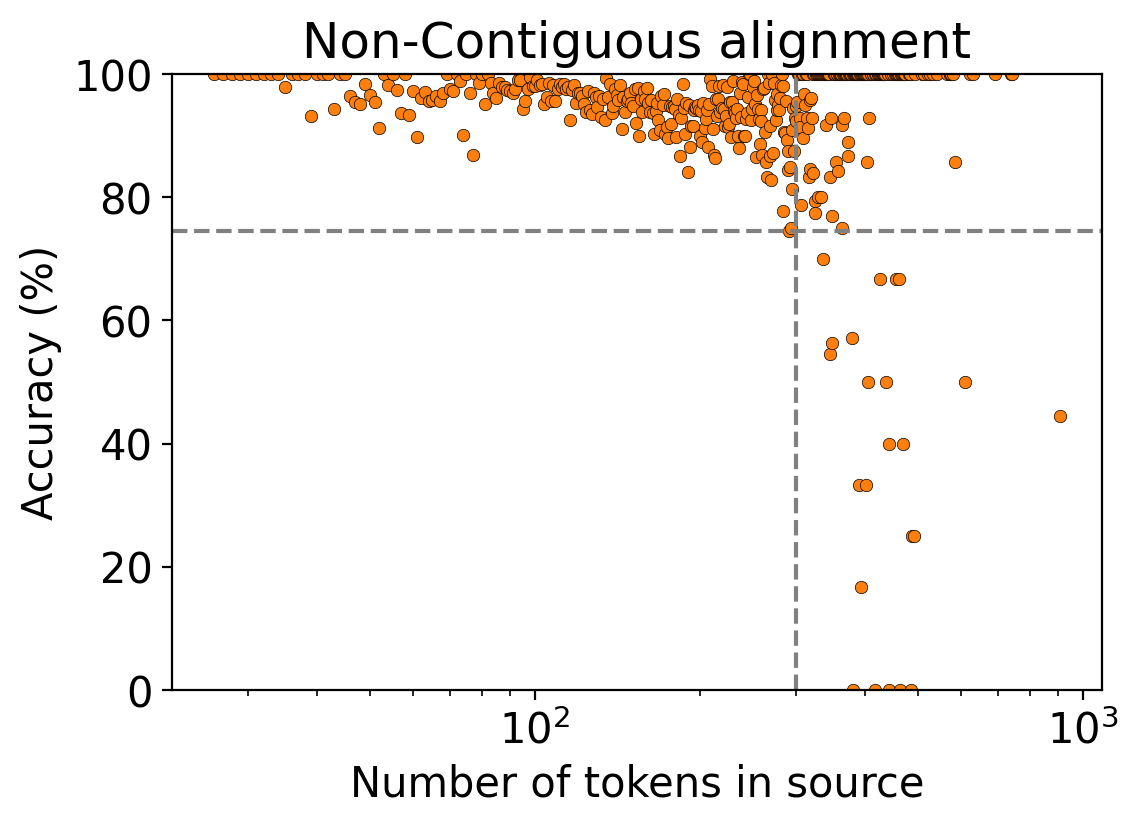

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# --- pick which accuracy to use ---------------------------------------------
method = "custom_found"  # or "lcs_found", "difflib_found", "naive_found"

# build accuracy table: one row per token length
acc_by_tokens = (
    tacc[method]
    .reset_index()  # ["ntks_ctx", method]
    .rename(columns={"ntks_ctx": "n_tokens",
                     method: "accuracy"})
)

# sort by token length (optional)
acc_by_tokens = acc_by_tokens.sort_values("n_tokens")

# --- plot: tokens vs accuracy -----------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

sc = ax.scatter(
    acc_by_tokens["n_tokens"],
    acc_by_tokens["accuracy"],
    s=20,
    edgecolor="k",
    linewidths=0.25,
    facecolor="#ff7f0e"
)
ax.axvline(300, color="grey", linestyle="--")
cu_ntks = 300
min_acc = acc_by_tokens["accuracy"][acc_by_tokens["n_tokens"]<=cu_ntks].min()
ax.axhline(min_acc, color="grey", linestyle="--")

ax.set(
    xlabel="Number of tokens in source",
    ylabel="Accuracy (%)",
    xscale="log",       # useful if lengths span orders of magnitude
    ylim=(0, 100),
    title="Non-Contiguous alignment"
)

plt.show()

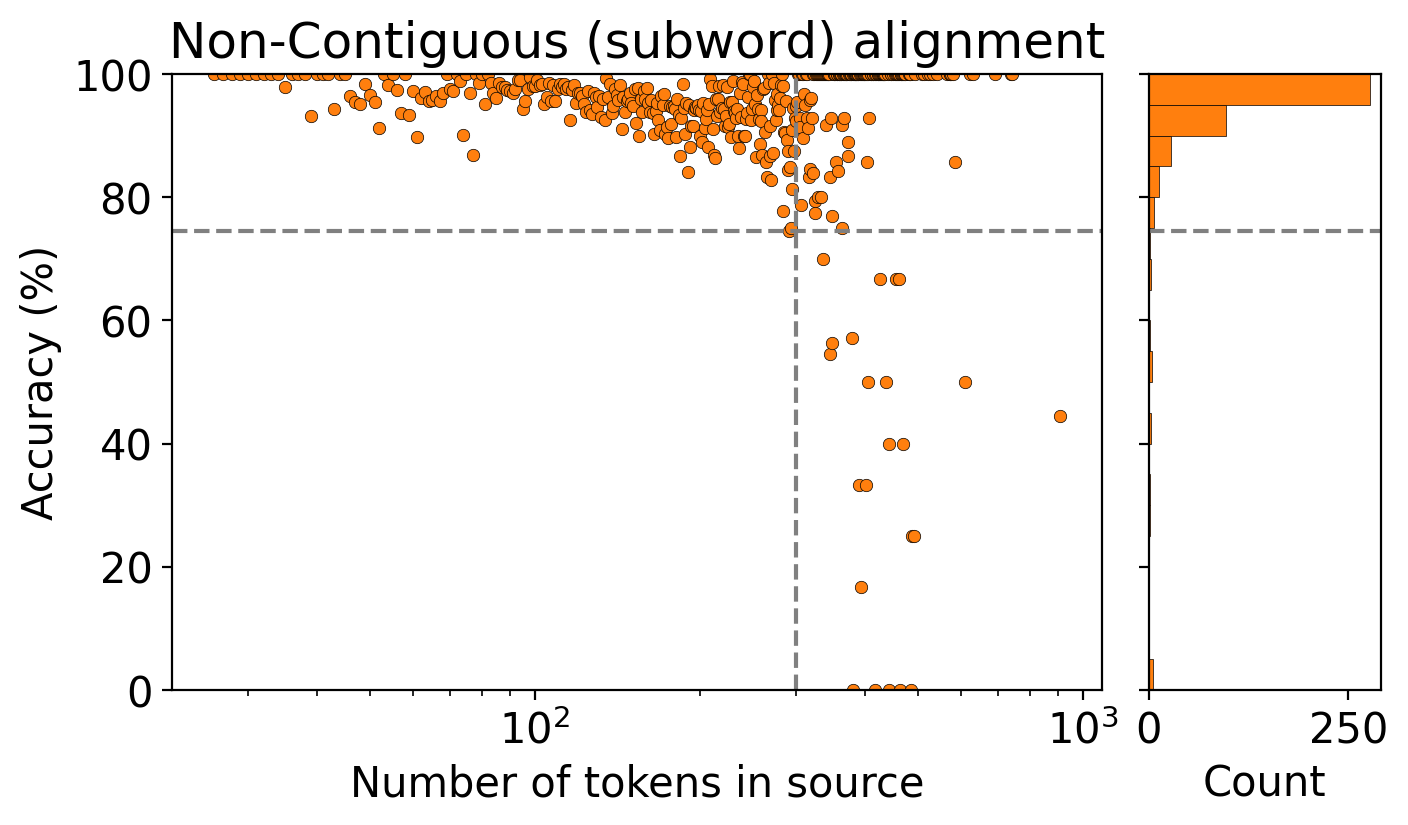

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# --- pick which accuracy to use ---------------------------------------------
method = "custom_found"  # or "lcs_found", "difflib_found", "naive_found"

acc_by_tokens = (
    tacc[method]
    .reset_index()
    .rename(columns={"ntks_ctx": "n_tokens", method: "accuracy"})
    .sort_values("n_tokens")
)

# --- plot: tokens vs accuracy -----------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(
    acc_by_tokens["n_tokens"],
    acc_by_tokens["accuracy"],
    s=20,
    edgecolor="k",
    linewidths=0.25,
    facecolor="#ff7f0e",
)

cu_ntks = 300
ax.axvline(cu_ntks, color="grey", linestyle="--")
min_acc = acc_by_tokens.loc[acc_by_tokens["n_tokens"] <= cu_ntks, "accuracy"].min()
ax.axhline(min_acc, color="grey", linestyle="--")

ax.set(
    xlabel="Number of tokens in source",
    ylabel="Accuracy (%)",
    xscale="log",
    ylim=(0, 100),
    title="Non-Contiguous (subword) alignment",
)

# --- right marginal: accuracy distribution -----------------------------------
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)

bins = np.arange(0, 101, 5)
ax_histy.hist(
    acc_by_tokens["accuracy"],
    bins=bins,
    orientation="horizontal",
    color="#ff7f0e",
    edgecolor="k",
    linewidth=0.25,
)

# same hline on marginal
ax_histy.axhline(min_acc, color="grey", linestyle="--")

ax_histy.tick_params(axis="x", labelbottom=True)
plt.setp(ax_histy.get_yticklabels(), visible=False)

ax_histy.set_xlabel("Count")

plt.show()

In [48]:
tacc.mean(), wacc.mean()

(custom_found     92.611763
 lcs_found        87.821245
 difflib_found    78.584907
 naive_found       0.042136
 dtype: float64,
 custom_found     85.251025
 lcs_found        81.163870
 difflib_found    74.514701
 naive_found       0.042136
 dtype: float64)

In [49]:
import pandas as pd

def compute_stats(texts_w, texts_t):
    chars = texts_w.str.len()
    ws = texts_w.apply(lambda s: len(s.split()))
    toks = texts_t.apply(lambda s: len(tokenize(s)[0]))
    return {
        "Char/Sample": chars.mean(),
        "WS/Sample": ws.mean(),
        "Tok/Sample": toks.mean(),
        "N Samples": texts_w.nunique()
    }

source_stats = compute_stats(
    pd.Series(wdf.source.unique()),
    pd.Series(tdf.source.unique())
)

target_stats = compute_stats(
    pd.Series(wdf.target.unique()),
    pd.Series(tdf.target.unique())
)

table = pd.DataFrame([source_stats, target_stats], index=["source", "target"])
table = table.round(0)
table

,Char/Sample,WS/Sample,Tok/Sample,N Samples
source,745.0,118.0,156.0,15928
target,38.0,6.0,8.0,42609


In [15]:
tdf.query("custom_same == True").reset_index()[["source", "target", "ablate_target"]].iloc[0].ablate_target

' the zone'

In [16]:
check = tdf.query("custom_same == False").reset_index()[["source", "target", "ablate_target", "custom_aln", "custom_text", "difflib_text", "difflib_aln"]]
idx = 1

In [17]:
check.iloc[0].source

"Utrecht's cityscape is dominated by the Dom Tower, the tallest belfry in the Netherlands and originally part of the Cathedral of Saint Martin. An ongoing debate is over whether any building in or near the centre of town should surpass the Dom Tower in height (112 m). Nevertheless, some tall buildings are now being constructed that will become part of the skyline of Utrecht. The second tallest building of the city, the Rabobank-tower, was completed in 2010 and stands 105 m (344.49 ft) tall. Two antennas will increase that height to 120 m (393.70 ft). Two other buildings were constructed around the Nieuw Galgenwaard stadium (2007). These buildings, the 'Kantoortoren Galghenwert' and 'Apollo Residence', stand 85.5 and 64.5 metres high respectively."

In [18]:
source = " (344.49 ft) tall. Two antennas will increase that height to 120 m (393.70 ft). Two other buildings were constructed around the Nieuw Galgenwaard stadium (2007)."
source = "Utrecht's cityscape is dominated by the Dom Tower, the tallest belfry in the Netherlands and originally part of the Cathedral of Saint Martin. An ongoing debate is over whether any building in or near the centre of town should surpass the Dom Tower in height (112 m). Nevertheless, some tall buildings are now being constructed that will become part of the skyline of Utrecht. The second tallest building of the city, the Rabobank-tower, was completed in 2010 and stands 105 m (344.49 ft) tall. Two antennas will increase that height to 120 m (393.70 ft). Two other buildings were constructed around the Nieuw Galgenwaard stadium (2007). These buildings, the 'Kantoortoren Galghenwert' and 'Apollo Residence', stand 85.5 and 64.5 metres high respectively."
target = ' the Nieuw Galgenwaard (2007)'

In [19]:
align_ng(source, target, "token")

[]

In [20]:
[i["token"] for i in tokenize("The man is ironing his shirt")[0]]

['The', ' man', ' is', ' iron', 'ing', ' his', ' shirt']

In [21]:
"The man is ironing his shirt".split(" ")

['The', 'man', 'is', 'ironing', 'his', 'shirt']

In [22]:
check.iloc[idx].target

' low rise, low traffic installations'

In [23]:
tokenize(' considered themselves the political heirs of Rome, but at l')[0]

[{'token': ' considered', 'enc_token': 6646, 'start_idx': 0, 'end_idx': 11},
 {'token': ' themselves', 'enc_token': 5694, 'start_idx': 11, 'end_idx': 22},
 {'token': ' the', 'enc_token': 279, 'start_idx': 22, 'end_idx': 26},
 {'token': ' political', 'enc_token': 5054, 'start_idx': 26, 'end_idx': 36},
 {'token': ' heirs', 'enc_token': 91401, 'start_idx': 36, 'end_idx': 42},
 {'token': ' of', 'enc_token': 315, 'start_idx': 42, 'end_idx': 45},
 {'token': ' Rome', 'enc_token': 22463, 'start_idx': 45, 'end_idx': 50},
 {'token': ',', 'enc_token': 11, 'start_idx': 50, 'end_idx': 51},
 {'token': ' but', 'enc_token': 719, 'start_idx': 51, 'end_idx': 55},
 {'token': ' at', 'enc_token': 520, 'start_idx': 55, 'end_idx': 58},
 {'token': ' l', 'enc_token': 326, 'start_idx': 58, 'end_idx': 60}]

In [24]:
tokenize(check.iloc[idx].ablate_target)[0]

[{'token': ' low', 'enc_token': 3428, 'start_idx': 0, 'end_idx': 4},
 {'token': ' low', 'enc_token': 3428, 'start_idx': 4, 'end_idx': 8},
 {'token': ' traffic', 'enc_token': 9629, 'start_idx': 8, 'end_idx': 16},
 {'token': ' installations',
  'enc_token': 45218,
  'start_idx': 16,
  'end_idx': 30}]

In [25]:
check.iloc[idx].target

' low rise, low traffic installations'

In [26]:
check.iloc[idx].ablate_target

' low low traffic installations'

In [27]:
check.iloc[idx].custom_text

' low traffic installations'

In [28]:
check.iloc[idx].difflib_text

' low low traffic installations'

In [29]:
check.iloc[idx].difflib_aln

[[{'token': ' low', 'enc_token': 3428, 'start_idx': 3, 'end_idx': 7},
  {'token': ' low', 'enc_token': 3428, 'start_idx': 119, 'end_idx': 123},
  {'token': ' traffic', 'enc_token': 9629, 'start_idx': 123, 'end_idx': 131},
  {'token': ' installations',
   'enc_token': 45218,
   'start_idx': 131,
   'end_idx': 145}]]

In [30]:
from taln.taln_aln import (
    build_index,
    align_target,
    group_ngrams, 
    group_tokens,
)

In [31]:
source = check.iloc[idx].source
target = check.iloc[idx].target
ablated = check.iloc[idx].ablate_target
ttype = "token"

In [32]:
source

'The low mechanical complexity of hydraulic elevators in comparison to traction elevators makes them ideal for low rise, low traffic installations. They are less energy efficient as the pump works against gravity to push the car and its passengers upwards; this energy is lost when the car descends on its own weight. The high current draw of the pump when starting up also places higher demands on a building’s electrical system. There are also environmental concerns should the lifting cylinder leak fluid into the ground.'

In [33]:
source = 'The terms used to define Greekness have varied throughout history but were never limited or completely identified with membership to a Greek state. By Western standards, the term Greeks has traditionally referred to any native speakers of the Greek language, whether Mycenaean, Byzantine or modern Greek. Byzantine Greeks called themselves Romioi and considered themselves the political heirs of Rome, but at least by the 12th century a growing number of those educated, deemed themselves the heirs '

In [34]:
source_tokens, source_t2w = tokenize(source, ttype)
target_tokens, target_t2w = tokenize(' considered themselves the heirs of Rome', ttype)

source_enc_tokens = [t["enc_token"] for t in source_tokens]
target_enc_tokens = [t["enc_token"] for t in target_tokens]
import difflib
matcher = difflib.SequenceMatcher(None, source_enc_tokens, target_enc_tokens)

alignments = []
for block in matcher.get_matching_blocks():
    if block.size > 0:
        alignment = source_tokens[block.a : block.a + block.size]
        alignments.append(alignment)
# flatten the list of lists
alignments = [item for sublist in alignments for item in sublist]
alignments

[{'token': ' considered', 'enc_token': 6646, 'start_idx': 350, 'end_idx': 361},
 {'token': ' themselves', 'enc_token': 5694, 'start_idx': 361, 'end_idx': 372},
 {'token': ' the', 'enc_token': 279, 'start_idx': 372, 'end_idx': 376},
 {'token': ' heirs', 'enc_token': 91401, 'start_idx': 386, 'end_idx': 392},
 {'token': ' of', 'enc_token': 315, 'start_idx': 392, 'end_idx': 395},
 {'token': ' Rome', 'enc_token': 22463, 'start_idx': 395, 'end_idx': 400}]

In [35]:
align_difflib(source, target, ttype)

[[{'token': ',', 'enc_token': 11, 'start_idx': 168, 'end_idx': 169}]]

In [36]:
alignments

[{'token': ' considered', 'enc_token': 6646, 'start_idx': 350, 'end_idx': 361},
 {'token': ' themselves', 'enc_token': 5694, 'start_idx': 361, 'end_idx': 372},
 {'token': ' the', 'enc_token': 279, 'start_idx': 372, 'end_idx': 376},
 {'token': ' heirs', 'enc_token': 91401, 'start_idx': 386, 'end_idx': 392},
 {'token': ' of', 'enc_token': 315, 'start_idx': 392, 'end_idx': 395},
 {'token': ' Rome', 'enc_token': 22463, 'start_idx': 395, 'end_idx': 400}]

In [37]:
target_tokens

[{'token': ' considered', 'enc_token': 6646, 'start_idx': 0, 'end_idx': 11},
 {'token': ' themselves', 'enc_token': 5694, 'start_idx': 11, 'end_idx': 22},
 {'token': ' the', 'enc_token': 279, 'start_idx': 22, 'end_idx': 26},
 {'token': ' heirs', 'enc_token': 91401, 'start_idx': 26, 'end_idx': 32},
 {'token': ' of', 'enc_token': 315, 'start_idx': 32, 'end_idx': 35},
 {'token': ' Rome', 'enc_token': 22463, 'start_idx': 35, 'end_idx': 40}]

In [38]:
alignments

[{'token': ' considered', 'enc_token': 6646, 'start_idx': 350, 'end_idx': 361},
 {'token': ' themselves', 'enc_token': 5694, 'start_idx': 361, 'end_idx': 372},
 {'token': ' the', 'enc_token': 279, 'start_idx': 372, 'end_idx': 376},
 {'token': ' heirs', 'enc_token': 91401, 'start_idx': 386, 'end_idx': 392},
 {'token': ' of', 'enc_token': 315, 'start_idx': 392, 'end_idx': 395},
 {'token': ' Rome', 'enc_token': 22463, 'start_idx': 395, 'end_idx': 400}]

In [39]:
align_difflib(source, ablated, ttype)

[[]]

In [40]:
alignments

[{'token': ' considered', 'enc_token': 6646, 'start_idx': 350, 'end_idx': 361},
 {'token': ' themselves', 'enc_token': 5694, 'start_idx': 361, 'end_idx': 372},
 {'token': ' the', 'enc_token': 279, 'start_idx': 372, 'end_idx': 376},
 {'token': ' heirs', 'enc_token': 91401, 'start_idx': 386, 'end_idx': 392},
 {'token': ' of', 'enc_token': 315, 'start_idx': 392, 'end_idx': 395},
 {'token': ' Rome', 'enc_token': 22463, 'start_idx': 395, 'end_idx': 400}]

In [41]:
check.iloc[idx].source

'The low mechanical complexity of hydraulic elevators in comparison to traction elevators makes them ideal for low rise, low traffic installations. They are less energy efficient as the pump works against gravity to push the car and its passengers upwards; this energy is lost when the car descends on its own weight. The high current draw of the pump when starting up also places higher demands on a building’s electrical system. There are also environmental concerns should the lifting cylinder leak fluid into the ground.'

In [42]:
tokenize(check.iloc[idx].source)[0]

[{'token': 'The', 'enc_token': 791, 'start_idx': 0, 'end_idx': 3},
 {'token': ' low', 'enc_token': 3428, 'start_idx': 3, 'end_idx': 7},
 {'token': ' mechanical', 'enc_token': 22936, 'start_idx': 7, 'end_idx': 18},
 {'token': ' complexity', 'enc_token': 23965, 'start_idx': 18, 'end_idx': 29},
 {'token': ' of', 'enc_token': 315, 'start_idx': 29, 'end_idx': 32},
 {'token': ' hydraulic', 'enc_token': 44175, 'start_idx': 32, 'end_idx': 42},
 {'token': ' elev', 'enc_token': 12231, 'start_idx': 42, 'end_idx': 47},
 {'token': 'ators', 'enc_token': 3046, 'start_idx': 47, 'end_idx': 52},
 {'token': ' in', 'enc_token': 304, 'start_idx': 52, 'end_idx': 55},
 {'token': ' comparison', 'enc_token': 12593, 'start_idx': 55, 'end_idx': 66},
 {'token': ' to', 'enc_token': 311, 'start_idx': 66, 'end_idx': 69},
 {'token': ' traction', 'enc_token': 47955, 'start_idx': 69, 'end_idx': 78},
 {'token': ' elev', 'enc_token': 12231, 'start_idx': 78, 'end_idx': 83},
 {'token': 'ators', 'enc_token': 3046, 'start_id

In [43]:
ngram_to_id[(434,)]

NameError: name 'ngram_to_id' is not defined

In [ ]:
ngram_to_id.get(tuple(target_ngram), None)


In [ ]:
enc_tokens

[220, 22, 13, 20, 3610, 11441, 320, 2148, 13, 20, 3610, 51659, 3647, 847, 8]

In [ ]:
tokens

[{'token': ' ', 'enc_token': 220, 'start_idx': 0, 'end_idx': 1},
 {'token': '7', 'enc_token': 22, 'start_idx': 1, 'end_idx': 2},
 {'token': '.', 'enc_token': 13, 'start_idx': 2, 'end_idx': 3},
 {'token': '5', 'enc_token': 20, 'start_idx': 3, 'end_idx': 4},
 {'token': ' million', 'enc_token': 3610, 'start_idx': 4, 'end_idx': 12},
 {'token': ' dollars', 'enc_token': 11441, 'start_idx': 12, 'end_idx': 20},
 {'token': ' (', 'enc_token': 320, 'start_idx': 20, 'end_idx': 22},
 {'token': '31', 'enc_token': 2148, 'start_idx': 22, 'end_idx': 24},
 {'token': '.', 'enc_token': 13, 'start_idx': 24, 'end_idx': 25},
 {'token': '5', 'enc_token': 20, 'start_idx': 25, 'end_idx': 26},
 {'token': ' million', 'enc_token': 3610, 'start_idx': 26, 'end_idx': 34},
 {'token': ' Reich', 'enc_token': 51659, 'start_idx': 34, 'end_idx': 40},
 {'token': 'sm', 'enc_token': 3647, 'start_idx': 40, 'end_idx': 42},
 {'token': 'ark', 'enc_token': 847, 'start_idx': 42, 'end_idx': 45},
 {'token': ')', 'enc_token': 8, 'star

In [ ]:
align_ng(check.iloc[idx].source, check.iloc[idx].ablate_target, "token")

[[{'token': ' ', 'enc_token': 220, 'start_idx': 2, 'end_idx': 3},
  {'token': '7', 'enc_token': 22, 'start_idx': 300, 'end_idx': 301},
  {'token': '.', 'enc_token': 13, 'start_idx': 301, 'end_idx': 302},
  {'token': '5', 'enc_token': 20, 'start_idx': 302, 'end_idx': 303},
  {'token': ' million', 'enc_token': 3610, 'start_idx': 303, 'end_idx': 311},
  {'token': ' dollars', 'enc_token': 11441, 'start_idx': 311, 'end_idx': 319},
  {'token': ' million', 'enc_token': 3610, 'start_idx': 325, 'end_idx': 333},
  {'token': ' Reich', 'enc_token': 51659, 'start_idx': 333, 'end_idx': 339},
  {'token': 'sm', 'enc_token': 3647, 'start_idx': 339, 'end_idx': 341},
  {'token': 'ark', 'enc_token': 847, 'start_idx': 341, 'end_idx': 344}],
 [{'token': ' ', 'enc_token': 220, 'start_idx': 13, 'end_idx': 14},
  {'token': '7', 'enc_token': 22, 'start_idx': 300, 'end_idx': 301},
  {'token': '.', 'enc_token': 13, 'start_idx': 301, 'end_idx': 302},
  {'token': '5', 'enc_token': 20, 'start_idx': 302, 'end_idx': 3

In [ ]:
align_ng(check.iloc[idx].source, check.iloc[idx].target, "token")

[[{'token': ' ', 'enc_token': 220, 'start_idx': 2, 'end_idx': 3},
  {'token': '7', 'enc_token': 22, 'start_idx': 300, 'end_idx': 301},
  {'token': '.', 'enc_token': 13, 'start_idx': 301, 'end_idx': 302},
  {'token': '5', 'enc_token': 20, 'start_idx': 302, 'end_idx': 303},
  {'token': ' million', 'enc_token': 3610, 'start_idx': 303, 'end_idx': 311},
  {'token': ' dollars', 'enc_token': 11441, 'start_idx': 311, 'end_idx': 319},
  {'token': ' (', 'enc_token': 320, 'start_idx': 319, 'end_idx': 321},
  {'token': '31', 'enc_token': 2148, 'start_idx': 321, 'end_idx': 323},
  {'token': '.', 'enc_token': 13, 'start_idx': 323, 'end_idx': 324},
  {'token': '5', 'enc_token': 20, 'start_idx': 324, 'end_idx': 325},
  {'token': ' million', 'enc_token': 3610, 'start_idx': 325, 'end_idx': 333},
  {'token': ' Reich', 'enc_token': 51659, 'start_idx': 333, 'end_idx': 339},
  {'token': 'sm', 'enc_token': 3647, 'start_idx': 339, 'end_idx': 341},
  {'token': 'ark', 'enc_token': 847, 'start_idx': 341, 'end_id

In [ ]:
tokenize(check.iloc[idx].target)[0]

[{'token': ' ', 'enc_token': 220, 'start_idx': 0, 'end_idx': 1},
 {'token': '7', 'enc_token': 22, 'start_idx': 1, 'end_idx': 2},
 {'token': '.', 'enc_token': 13, 'start_idx': 2, 'end_idx': 3},
 {'token': '5', 'enc_token': 20, 'start_idx': 3, 'end_idx': 4},
 {'token': ' million', 'enc_token': 3610, 'start_idx': 4, 'end_idx': 12},
 {'token': ' dollars', 'enc_token': 11441, 'start_idx': 12, 'end_idx': 20},
 {'token': ' (', 'enc_token': 320, 'start_idx': 20, 'end_idx': 22},
 {'token': '31', 'enc_token': 2148, 'start_idx': 22, 'end_idx': 24},
 {'token': '.', 'enc_token': 13, 'start_idx': 24, 'end_idx': 25},
 {'token': '5', 'enc_token': 20, 'start_idx': 25, 'end_idx': 26},
 {'token': ' million', 'enc_token': 3610, 'start_idx': 26, 'end_idx': 34},
 {'token': ' Reich', 'enc_token': 51659, 'start_idx': 34, 'end_idx': 40},
 {'token': 'sm', 'enc_token': 3647, 'start_idx': 40, 'end_idx': 42},
 {'token': 'ark', 'enc_token': 847, 'start_idx': 42, 'end_idx': 45},
 {'token': ')', 'enc_token': 8, 'star

In [ ]:
check.iloc[idx].custom_text == check.iloc[idx].ablate_target

False

In [ ]:
check.iloc[idx].custom_aln

False

In [ ]:
align_ng(check.iloc[idx].source, check.iloc[idx].target, "token")

[[{'token': ' ', 'enc_token': 220, 'start_idx': 2, 'end_idx': 3},
  {'token': '7', 'enc_token': 22, 'start_idx': 300, 'end_idx': 301},
  {'token': '.', 'enc_token': 13, 'start_idx': 301, 'end_idx': 302},
  {'token': '5', 'enc_token': 20, 'start_idx': 302, 'end_idx': 303},
  {'token': ' million', 'enc_token': 3610, 'start_idx': 303, 'end_idx': 311},
  {'token': ' dollars', 'enc_token': 11441, 'start_idx': 311, 'end_idx': 319},
  {'token': ' (', 'enc_token': 320, 'start_idx': 319, 'end_idx': 321},
  {'token': '31', 'enc_token': 2148, 'start_idx': 321, 'end_idx': 323},
  {'token': '.', 'enc_token': 13, 'start_idx': 323, 'end_idx': 324},
  {'token': '5', 'enc_token': 20, 'start_idx': 324, 'end_idx': 325},
  {'token': ' million', 'enc_token': 3610, 'start_idx': 325, 'end_idx': 333},
  {'token': ' Reich', 'enc_token': 51659, 'start_idx': 333, 'end_idx': 339},
  {'token': 'sm', 'enc_token': 3647, 'start_idx': 339, 'end_idx': 341},
  {'token': 'ark', 'enc_token': 847, 'start_idx': 341, 'end_id

True

In [ ]:
tgt = " Civano"

In [ ]:
tmp = wdf.query(f"target == '{tgt}'")#[["target", "custom_text", "custom_same"]]

In [ ]:
tmp[["target", "ablate_target", "custom_text", "custom_same"]]

,target,ablate_target,custom_text,custom_same


In [ ]:
tmp["ablate_target"].values

array([' '], dtype=object)

In [ ]:
# Check this
tmp["ablate_target"].str.strip() == tmp["custom_text"].str.strip()

8    True
dtype: bool

In [ ]:
    wdf[f"{m}_same"] = wdf["ablate_target"].str.strip() == wdf[f"{m}_text"].str.strip()

In [ ]:
# custom
print(df["custom_same"].sum()/df.shape[0]*100)
print(df["lcs_same"].sum()/df.shape[0]*100)
print(df["difflib_same"].sum()/df.shape[0]*100)
print(df["naive_same"].sum()/df.shape[0]*100)

93.82102272727273
93.90827922077922
93.24472402597402
73.83116883116884


In [ ]:
# custom
print(wdf["custom_same"].sum()/wdf.shape[0]*100)
print(wdf["lcs_same"].sum()/wdf.shape[0]*100)
print(wdf["difflib_same"].sum()/wdf.shape[0]*100)
print(wdf["naive_same"].sum()/wdf.shape[0]*100)

75.88676948051948
75.9375
75.50527597402598
73.8372564935065


In [ ]:
print("done")

done


In [ ]:
print((df.apply(lambda row: any(item in row["custom_text"] for item in row["ablate_answer_text"]), axis=1)).sum() / len(df))
print((df["ablate_answer_text"] == df["lcs_text"]).sum() / len(df))
print((df["ablate_answer_text"] == df["difflib_text"]).sum() / len(df))

0.018087185418577754
0.9523989949347904
0.9428468870896981


In [ ]:
df[["ablate_answer_text", "custom_text"]].apply(lambda x: x[0] in x[1], axis=1).sum() / len(df)

/var/folders/89/1b_bcy3s39g4nkyxbdxvgzt40000gn/T/ipykernel_78057/3814322113.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df[["ablate_answer_text", "custom_text"]].apply(lambda x: x[0] in x[1], axis=1).sum() / len(df)


np.float64(0.9437642085111474)

In [ ]:
df["custom_coverage"] = df["custom_aln"].apply(lambda x: len(set([i["enc_token"] for i in x[0] if len(x) > 0])) if len(x) > 0 else 0) / df["nutks_abl_ans"]
df["lcs_coverage"] = df["lcs_aln"].apply(lambda x: len(set([i["enc_token"] for i in x[0] if len(x) > 0])) if len(x) > 0 else 0) / df["nutks_abl_ans"]
df["difflib_coverage"] = df["difflib_aln"].apply(lambda x: len(set([i["enc_token"] for i in x[0] if len(x) > 0])) if len(x) > 0 else 0) / df["nutks_abl_ans"]

In [ ]:
df["custom_coverage"]

0        1.0
1        1.0
2        1.0
3        1.0
5        1.0
        ... 
57573    0.5
57574    1.0
57575    1.0
57577    1.0
57578    1.0
Name: custom_coverage, Length: 50146, dtype: float64

custom_coverage 97.5540475997205
lcs_coverage 98.15693741668444
difflib_coverage 97.57467263050414


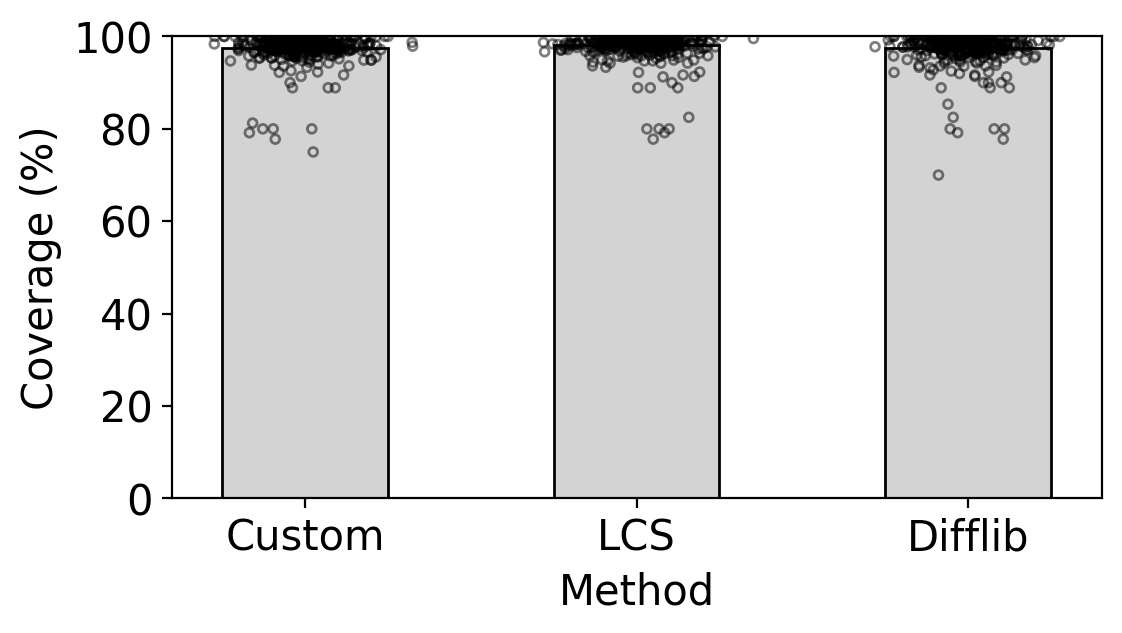

In [ ]:
fig, ax = plt.subplots(figsize=(6,3))

coverage = [df.groupby("ntks_ctx")[i].sum() / df.groupby("ntks_ctx")[i].count()*100 for i in ["custom_coverage", "lcs_coverage", "difflib_coverage"]]
x = np.arange(len(coverage[0]))
width = 0.5

for i, y in enumerate(coverage):
    x = np.random.normal(i, 0.1, size=len(y))
    ax.scatter(x, y.values, s=10, alpha=0.5, edgecolors="black", facecolors="none")
    ax.bar(i, y.mean(), width, label=y.name, zorder=-1, edgecolor="black", facecolor="lightgrey")
    print(y.name, y.mean())

ax.set(**{
    "ylabel": "Coverage (%)",
    "xlabel": "Method",
    "xticks": np.arange(len(coverage)),
    "xticklabels": ["Custom", "LCS", "Difflib"],
    "ylim": (0, 100),
})
plt.show()

In [ ]:
src = "the addition of distinct male and female epithelial populations "
tgt = " male epithelial populations"

src = "The cat sat on the mat and the cat looked at the sat dog"
tgt = " cat sat dog"

src = "The quick brown fox jumps over the lazy dog"
tgt = " quick fox lazy"

src = "A B A B A B A B"
tgt = " A B A"

src = "The party of the first part agrees that the party of the first part shall provide to the party of the second part, and the party of the second part agrees to accept from the party of the first part..."
tgt = " party first part provide second part"

src = " CD4+ T cells express high levels of IL-2. CD8+ T cells also express high levels of IFN-g"
tgt = " CD4+ cells"

In [ ]:
align_ng(src, tgt)

[[{'token': ' CD', 'enc_token': 11325, 'start_idx': 0, 'end_idx': 3},
  {'token': '4', 'enc_token': 19, 'start_idx': 3, 'end_idx': 4},
  {'token': '+', 'enc_token': 10, 'start_idx': 4, 'end_idx': 5},
  {'token': ' cells', 'enc_token': 7917, 'start_idx': 7, 'end_idx': 13}],
 [{'token': ' CD', 'enc_token': 11325, 'start_idx': 0, 'end_idx': 3},
  {'token': '4', 'enc_token': 19, 'start_idx': 3, 'end_idx': 4},
  {'token': '+', 'enc_token': 10, 'start_idx': 4, 'end_idx': 5},
  {'token': ' cells', 'enc_token': 7917, 'start_idx': 49, 'end_idx': 55}],
 [{'token': ' CD', 'enc_token': 11325, 'start_idx': 0, 'end_idx': 3},
  {'token': '4', 'enc_token': 19, 'start_idx': 3, 'end_idx': 4},
  {'token': '+', 'enc_token': 10, 'start_idx': 46, 'end_idx': 47},
  {'token': ' cells', 'enc_token': 7917, 'start_idx': 49, 'end_idx': 55}]]

In [ ]:
align_naive(src, tgt)

[[{'token': ' CD4+ cells', 'enc_token': -1, 'start_idx': -1, 'end_idx': -1}]]

In [ ]:
align_lcs(src, tgt)

[[{'token': ' CD', 'enc_token': 11325, 'start_idx': 0, 'end_idx': 3},
  {'token': '4', 'enc_token': 19, 'start_idx': 3, 'end_idx': 4},
  {'token': '+', 'enc_token': 10, 'start_idx': 46, 'end_idx': 47},
  {'token': ' cells', 'enc_token': 7917, 'start_idx': 49, 'end_idx': 55}]]

In [ ]:
align_difflib(src, tgt)

[[{'token': ' CD', 'enc_token': 11325, 'start_idx': 0, 'end_idx': 3},
  {'token': '4', 'enc_token': 19, 'start_idx': 3, 'end_idx': 4},
  {'token': '+', 'enc_token': 10, 'start_idx': 4, 'end_idx': 5},
  {'token': ' cells', 'enc_token': 7917, 'start_idx': 7, 'end_idx': 13}]]

In [ ]:
import difflib
source_tokens = tokenize(src)[0]
target_tokens = tokenize(tgt)[0]

source_enc_tokens = [t["enc_token"] for t in source_tokens]
target_enc_tokens = [t["enc_token"] for t in target_tokens]

matcher = difflib.SequenceMatcher(None, source_enc_tokens, target_enc_tokens)

alignments = []
for block in matcher.get_matching_blocks():
    if block.size > 0:
        alignment = source_tokens[block.a : block.a + block.size]
        alignments.append(alignment)
# flatten the list of lists
alignments = [item for sublist in alignments for item in sublist]